# 0. Model for Pre-Processing Assessment

- **Purpose:**  
  Establish a lightweight baseline to **quantify the impact** of each preprocessing step (feature engineering, resampling, etc.) before committing to the final pipeline.

- **Estimator:**  
  A simple regressor (`LightGBMRegressor` with default settings) so that differences in performance are driven by preprocessing, not by model complexity.

- **Validation Strategy:**  
  Use an **expanding-window** on your yearly data (e.g. train 2014–2019 → val 2020, train 2014–2020 → val 2021) to mimic real-world forecasting and avoid leakage.

- **Evaluation Metrics:**  
  Primary: **RMSE** (root mean squared error).  
  Secondary: **MAE**, **R²**—to ensure robustness across different error measures.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
import resreg
import itertools

In [3]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [4]:
def assessment_model(X_train, X_test, y_train, y_test):
    """
    Quickly evaluates the performance of a model after preprocessing,
    using a balanced LightGBM configuration.
    """
    model = LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=31,
        max_depth=6,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        learning_rate=0.05,
        n_estimators=150,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        verbosity=-1
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f"✅ Preprocessing Assessment — RMSE: {rmse:.4f}")
    
    return model

# 1. Feature Engineering
- Since this is a time-series-related dataset, the most recent years are reserved for the test set (Temporal Holdout with expanding window). This approach avoids data leakage — where the model might learn to predict past outcomes using information from the future — which would lead to unrealistic and overly optimistic test results. By splitting the data chronologically, we ensure that the evaluation reflects real-world performance, where future values are unknown during training."
- After checking the dataframe on EDA and manually, NDVI_li seems to be the best one that reflects reality. So the other 2 were droped.
_______________________

In [38]:
df = pd.read_csv("../datasets/weather_NDVI_harvest.csv").copy()
df.columns

Index(['市町村コード', '市町村名', 'year', 'Productivity', '作付面積', 'ET0_sum_veg',
       'ET0_sum_rep', 'PTI_sum_veg', 'PTI_sum_rep', 'PTU_sum_veg',
       'PTU_sum_rep', 'SWD_sum_veg', 'SWD_mean_veg', 'SWD_sum_rep',
       'SWD_mean_rep', 'VPD_sum_veg', 'VPD_sum_rep', 'GDD_sum_veg',
       'GDD_sum_rep', 'stress_combo_days_veg', 'stress_combo_days_rep',
       'ideal_combo_days_veg', 'ideal_combo_days_rep', 'ALLSKY_days_ideal_veg',
       'ALLSKY_days_low_veg', 'ALLSKY_days_extremely_low_veg',
       'ALLSKY_days_high_veg', 'ALLSKY_days_ideal_rep', 'ALLSKY_days_low_rep',
       'ALLSKY_days_extremely_low_rep', 'ALLSKY_days_high_rep', 'ALLSKY_5',
       'ALLSKY_6', 'ALLSKY_7', 'ALLSKY_8', 'RH2M_days_ideal_veg',
       'RH2M_days_high_veg', 'RH2M_days_very_high_veg', 'RH2M_days_ideal_rep',
       'RH2M_days_high_rep', 'RH2M_days_very_high_rep',
       'T2M_days_ideal_vegetative', 'T2M_days_low_vegetative',
       'T2M_days_extremely_low_vegetative', 'T2M_days_ideal_reproductive',
       'T2M_days

# Drop columns:
- ID columns: `['市町村コード']` -> Will not help the preprocessing, nor the model.
- Low information NDVI `['NDVI_li_9', 'NDVI_li_10']` -> months out of previous weather analysis.
- Future columns to remove: `['市町村名', 'year']`

In [39]:
# Drop ID col
df = df[['市町村名', 'year', 'Productivity', '作付面積', 'ET0_sum_veg',
         'ET0_sum_rep', 'PTI_sum_veg', 'PTI_sum_rep', 'PTU_sum_veg',
         'PTU_sum_rep', 'SWD_sum_veg', 'SWD_mean_veg', 'SWD_sum_rep',
         'SWD_mean_rep', 'VPD_sum_veg', 'VPD_sum_rep', 'GDD_sum_veg',
         'GDD_sum_rep', 'stress_combo_days_veg', 'stress_combo_days_rep',
         'ideal_combo_days_veg', 'ideal_combo_days_rep', 'ALLSKY_days_ideal_veg',
         'ALLSKY_days_low_veg', 'ALLSKY_days_extremely_low_veg',
         'ALLSKY_days_high_veg', 'ALLSKY_days_ideal_rep', 'ALLSKY_days_low_rep',
         'ALLSKY_days_extremely_low_rep', 'ALLSKY_days_high_rep', 'ALLSKY_5',
         'ALLSKY_6', 'ALLSKY_7', 'ALLSKY_8', 'RH2M_days_ideal_veg',
         'RH2M_days_high_veg', 'RH2M_days_very_high_veg', 'RH2M_days_ideal_rep',
         'RH2M_days_high_rep', 'RH2M_days_very_high_rep',
         'T2M_days_ideal_vegetative', 'T2M_days_low_vegetative',
         'T2M_days_extremely_low_vegetative', 'T2M_days_ideal_reproductive',
         'T2M_days_low_reproductive', 'T2M_days_extremely_low_reproductive',
         'T2M_5', 'T2M_6', 'T2M_7', 'T2M_8',
         '緯度', '経度', 'NDVI_li_5', 'NDVI_li_6', 'NDVI_li_7', 'NDVI_li_8']]

# 1.1. 🌱 NDVI-based Features for Crop Yield Prediction
1. NDVI_active_count
Definition: <br>
This feature counts the number of months (from May to August) where the NDVI value is greater than or equal to 0.6.

Why it matters: <br>
An NDVI value above 0.6 generally indicates strong photosynthetic activity, which reflects healthy vegetation growth. By counting how many of these months show such activity, the model gains insight into how consistently the crop remained in a productive state during the growing season. Crops that maintain high NDVI longer are likely to yield better.

2. NDVI_AUC (Area Under Curve)
Definition: <br>
This feature is the sum of the monthly NDVI values between May and August, effectively approximating the area under the NDVI curve for the season.

Why it matters: <br>
This metric captures the total vegetative performance across the critical months. Even if a crop doesn't have consistently high NDVI, a few very strong months can still lead to a good yield. NDVI_AUC reflects cumulative vigor and is especially useful in quantifying variability between different city-seasons or fields.

In [40]:
# NDVI columns per month (May to August)
ndvi_cols = ['NDVI_li_5', 'NDVI_li_6', 'NDVI_li_7', 'NDVI_li_8']

# NDVI_ACTIVE_COUNT: number of months with NDVI ≥ 0.6 (indicative of vegetative activity)
df['NDVI_active_count'] = df[ndvi_cols].ge(0.6).sum(axis=1)

# NDVI_AUC: simple area under the NDVI curve (sum over the months, equally spaced)
df['NDVI_AUC'] = df[ndvi_cols].sum(axis=1)

# NDVI_MEAN: average NDVI from May to August
df['NDVI_mean'] = df[ndvi_cols].mean(axis=1)

# NDVI_MAX: peak NDVI during the period
df['NDVI_max'] = df[ndvi_cols].max(axis=1)

# NDVI_STD: standard deviation (instability indicator)
df['NDVI_std'] = df[ndvi_cols].std(axis=1)

# NDVI_RANGE: max - min (variability of the signal)
df['NDVI_range'] = df[ndvi_cols].max(axis=1) - df[ndvi_cols].min(axis=1)

# NDVI_MIN: minimum NDVI in the period
df['NDVI_min'] = df[ndvi_cols].min(axis=1)

# NDVI_MEDIAN: more robust to clouds/outliers
df['NDVI_median'] = df[ndvi_cols].median(axis=1)

# NDVI_TIME_TO_MAX: index of month with highest NDVI (0 = May, 1 = June, ...)
df['NDVI_time_to_max'] = df[ndvi_cols].idxmax(axis=1).apply(lambda col: ndvi_cols.index(col))

# Months list
months_list = [5, 6, 7, 8]

# ALLSKY x NDVI each month
for month in months_list:
    df[f'ALLSKY_NDVI_{month}'] = df[f'ALLSKY_{month}'] * df[f'NDVI_li_{month}']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 69 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   市町村名                                 1051 non-null   object 
 1   year                                 1051 non-null   int64  
 2   Productivity                         1051 non-null   float64
 3   作付面積                                 1051 non-null   float64
 4   ET0_sum_veg                          1051 non-null   float64
 5   ET0_sum_rep                          1051 non-null   float64
 6   PTI_sum_veg                          1051 non-null   float64
 7   PTI_sum_rep                          1051 non-null   float64
 8   PTU_sum_veg                          1051 non-null   float64
 9   PTU_sum_rep                          1051 non-null   float64
 10  SWD_sum_veg                          1051 non-null   float64
 11  SWD_mean_veg                  

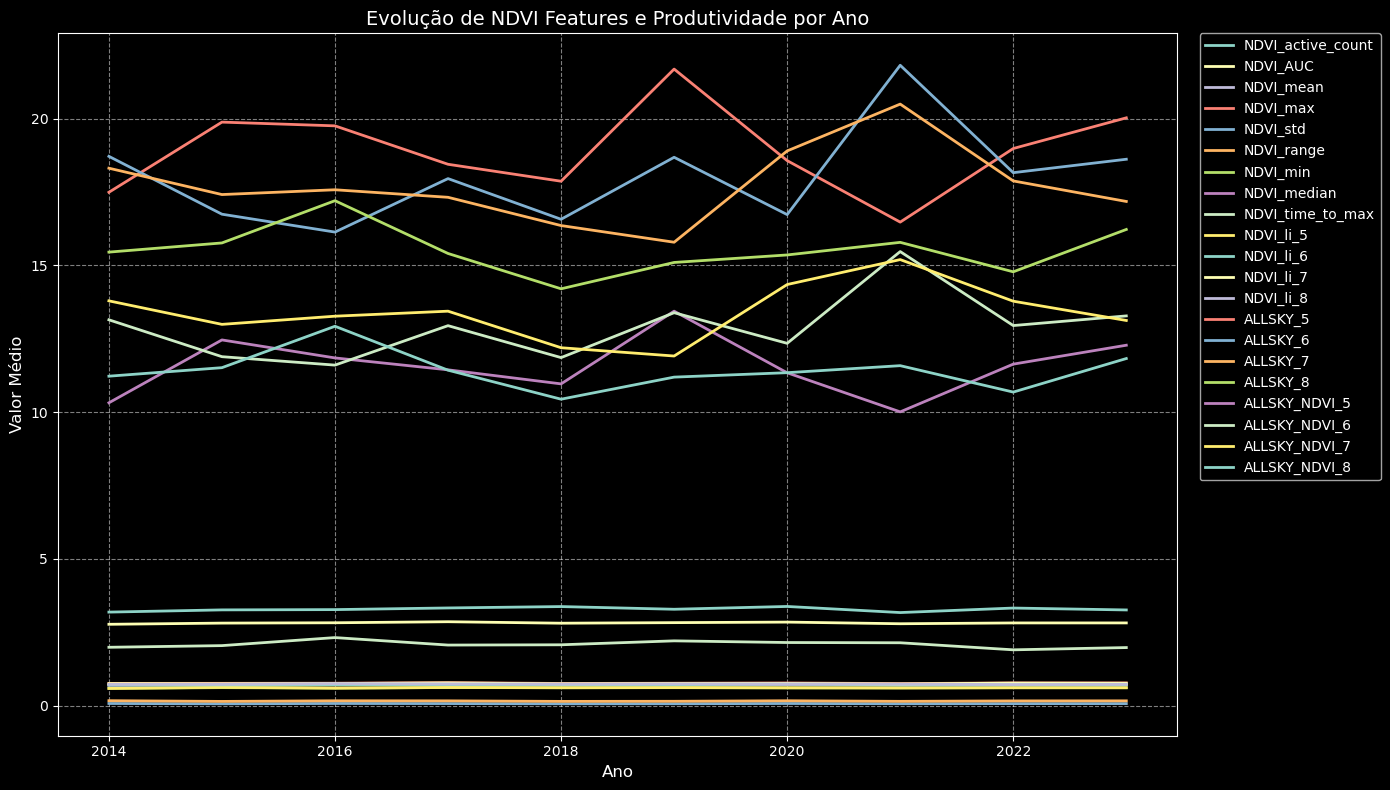

In [41]:
import matplotlib.pyplot as plt

# Lista das colunas NDVI derivadas + Productivity
cols_to_plot = [
    'NDVI_active_count', 'NDVI_AUC', 'NDVI_mean', 'NDVI_max',
    'NDVI_std', 'NDVI_range', 'NDVI_min', 'NDVI_median', 'NDVI_time_to_max',
    'NDVI_li_5', 'NDVI_li_6', 'NDVI_li_7', 'NDVI_li_8',
    'ALLSKY_5', 'ALLSKY_6', 'ALLSKY_7', 'ALLSKY_8',
    'ALLSKY_NDVI_5', 'ALLSKY_NDVI_6', 'ALLSKY_NDVI_7', 'ALLSKY_NDVI_8'
]

# Agrupar por ano e tirar a média para cada feature
df_grouped = df.groupby('year')[cols_to_plot].mean().reset_index()

# Plotando
plt.style.use('dark_background')
plt.figure(figsize=(14, 8))

for col in cols_to_plot:
    plt.plot(df_grouped['year'], df_grouped[col], label=col, linewidth=2)

plt.xlabel('Ano', fontsize=12)
plt.ylabel('Valor Médio', fontsize=12)
plt.title('Evolução de NDVI Features e Produtividade por Ano', fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 1.2. 🏙️ Historic 'Productivity' Mean per City as a New Feature, and Train/Test Split
______________________________
Validation years: 2020 and 2021

Test years: 2022 and 2023

To ensure a fair evaluation and avoid data leakage, it's crucial to split the data into train/validation/test sets before calculating the historical mean productivity per city. This prevents future information from being included in the training process, preserving the integrity of the model.

The historical mean will be computed using only data prior to the target year:

For validation in 2020, use data from [2014 to 2019] <br>
For validation in 2021, use data from [2014 to 2020] <br>
For testing in 2022, use data from [2014 to 2021] <br>
For testing in 2023, use data from [2014 to 2022] <br>

**Historic Productivity Mean per City <br>
This feature replaces the raw latitude / longitude pair with a single scalar that reflects each city’s typical yield, calculated from all past years up to (but not including) the target year.**

**In Notebook 04 we saw that latitude and longitude can help separate high-yield from low-yield regions, but decision-tree models must learn that separation through many axis-aligned splits. By precomputing each city’s historical average productivity, we provide the model with one one-dimensional, location-aware feature that:**

- Encodes spatial patterns (cities that are consistently more or less productive)

- Reduces the number of splits needed to distinguish regions

- Improves interpretability and training speed without sacrificing performance

In [42]:
def temporal_aware_train_test_split(df, year_predict, provide_X_y=False):
    # Train test split
    df_train = df[df['year'] < year_predict].copy()
    df_test = df[df['year'] == year_predict].copy()
    
    if provide_X_y:
        # Obtain X_train, X_test, y_train, y_test
        y_train = df_train['Productivity']
        y_test = df_test['Productivity']

        X_train = df_train.drop(columns=['市町村名', 'Productivity', 'year'])
        X_test = df_test.drop(columns=['市町村名', 'Productivity', 'year'])
        return X_train, X_test, y_train, y_test
    else:
        return df_train, df_test

In [43]:
# Assess with Model:
print("Validation 2020:")
X_train, X_test, y_train, y_test = temporal_aware_train_test_split(df=df,
                                                                   year_predict=2020,
                                                                   provide_X_y=True)
assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

print("Validation 2021:")
X_train, X_test, y_train, y_test = temporal_aware_train_test_split(df=df,
                                                                   year_predict=2021,
                                                                   provide_X_y=True)
assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 34.8283
Validation 2021:
✅ Preprocessing Assessment — RMSE: 32.2590


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              metric='rmse', n_estimators=150, objective='regression',
              random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
              verbosity=-1)

In [44]:
def add_city_historical_mean_feature(df_train, df_test, year_predict):
    """
    Adds a feature representing the historical mean productivity per city
    for a given prediction year, avoiding lookahead bias.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing at least city, year, and target columns.
        year_predict (int): The year to isolate as validation/test. Data before this year is used to compute means.
        city_col (str): Name of the column indicating city/region.
        target_col (str): Name of the column containing the productivity target.
        fillna_global_mean (bool): Whether to fill missing cities in test set with global mean from training.

    Returns:
        tuple (pd.DataFrame, pd.DataFrame): Modified training and test DataFrames with the new feature.
    """

    # Create a dictionary with the mean yield per city (no lookahead!)
    mean_yield_by_city = df_train.groupby('市町村名')['Productivity'].mean().to_dict()

    # Assign the mean values directly to X_train, like a fit_transform
    df_train['mean_productivity_city'] = df_train['市町村名'].map(mean_yield_by_city)

    # Apply the same mean values to the corresponding cities in X_test, like a transform
    df_test['mean_productivity_city'] = df_test['市町村名'].map(mean_yield_by_city)
    
    # Obtain X_train, X_test, y_train, y_test
    y_train = df_train['Productivity']
    y_test = df_test['Productivity']

    X_train = df_train.drop(columns=['市町村名', 'Productivity', 'year'])
    X_test = df_test.drop(columns=['市町村名', 'Productivity', 'year'])
    
    return X_train, X_test, y_train, y_test

In [45]:
# Assess with Model:
print("Validation 2020:")
df_train, df_test = temporal_aware_train_test_split(df=df,
                                                    year_predict=2020)
X_train, X_test, y_train, y_test = add_city_historical_mean_feature(df_train=df_train,
                                                                    df_test=df_test,
                                                                    year_predict=2020)

assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

print("Validation 2021:")
df_train, df_test = temporal_aware_train_test_split(df=df,
                                                    year_predict=2021)
X_train, X_test, y_train, y_test = add_city_historical_mean_feature(df_train=df_train,
                                                                    df_test=df_test,
                                                                    year_predict=2021)
assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 30.1821
Validation 2021:
✅ Preprocessing Assessment — RMSE: 23.9455


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              metric='rmse', n_estimators=150, objective='regression',
              random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
              verbosity=-1)

# 1.2.2. Trimmed Historic Productivity Mean (avoids extreme values when calculating the average productivity per city per year)
- The previous assessed Mean may be influenced by extremes (outliers) from the target.
______________________________

In [46]:
def trimmed_add_city_historical_mean_feature(df_train, df_test, year_predict):
    """
    Adds a feature representing the historical trimmed mean productivity per city
    for a given prediction year, avoiding lookahead bias.

    For each city, the minimum and maximum productivity values are excluded 
    before calculating the mean.

    Returns:
        tuple (pd.DataFrame, pd.DataFrame): Modified training and test DataFrames with the new feature.
    """

    # Create dictionary: trimmed mean productivity per city (excluding min and max)
    mean_yield_by_city = {}
    for city, group in df_train.groupby('市町村名')['Productivity']:
        if len(group) > 2:
            trimmed_group = group.drop([group.idxmin(), group.idxmax()])
            mean_yield_by_city[city] = trimmed_group.mean()
        else:
            # If there are only 2 or fewer values, just take the regular mean
            mean_yield_by_city[city] = group.mean()

    # Assign the trimmed mean values to training set
    df_train['trimmed_mean_productivity_city'] = df_train['市町村名'].map(mean_yield_by_city)

    # Apply the same trimmed mean values to test set
    df_test['trimmed_mean_productivity_city'] = df_test['市町村名'].map(mean_yield_by_city)
    
    # Separate features and target
    y_train = df_train['Productivity']
    y_test = df_test['Productivity']

    X_train = df_train.drop(columns=['市町村名', 'Productivity', 'year'])
    X_test = df_test.drop(columns=['市町村名', 'Productivity', 'year'])
    
    return X_train, X_test, y_train, y_test

In [47]:
# Assess with Model:
print("Validation 2020:")
df_train, df_test = temporal_aware_train_test_split(df=df,
                                                    year_predict=2020)
X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(df_train=df_train,
                                                                            df_test=df_test,
                                                                            year_predict=2020)

assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

print("Validation 2021:")
df_train, df_test = temporal_aware_train_test_split(df=df,
                                                    year_predict=2021)
X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(df_train=df_train,
                                                                            df_test=df_test,
                                                                            year_predict=2021)
assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.0180
Validation 2021:
✅ Preprocessing Assessment — RMSE: 25.2765


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              metric='rmse', n_estimators=150, objective='regression',
              random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
              verbosity=-1)

In [48]:
# Assess with Model:
print("Validation 2020:")
df_train, df_test = temporal_aware_train_test_split(df=df,
                                                    year_predict=2020)
X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(df_train=df_train,
                                                                            df_test=df_test,
                                                                            year_predict=2020)
X_train, X_test, y_train, y_test = add_city_historical_mean_feature(df_train=df_train,
                                                                    df_test=df_test,
                                                                    year_predict=2020)

assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

print("Validation 2021:")
df_train, df_test = temporal_aware_train_test_split(df=df,
                                                    year_predict=2021)
X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(df_train=df_train,
                                                                            df_test=df_test,
                                                                            year_predict=2021)
X_train, X_test, y_train, y_test = add_city_historical_mean_feature(df_train=df_train,
                                                                    df_test=df_test,
                                                                    year_predict=2021)
assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.4524
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.8427


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              metric='rmse', n_estimators=150, objective='regression',
              random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
              verbosity=-1)

# 1.3. ⚖️ SMOTER for Rebalancing Continuous Targets
What is SMOTER?
SMOTER (Synthetic Minority Over-sampling Technique for Regression) is an adaptation of the popular SMOTE algorithm, but designed for regression tasks instead of classification.

Bad performance and usually does not help Tree based models. So it was discarted

In [49]:
def apply_smoter(X_train, X_test, y_train, y_test, year_predict):
    
    # Instance SMOTER
    cl = np.percentile(y_train, 10)
    ch = np.percentile(y_train, 90) 

    relevance = resreg.sigmoid_relevance(y_train, cl=cl, ch=ch)
    X_res, y_res = resreg.smoter(X_train, y_train, relevance=relevance, relevance_threshold=0.6, k=10, over='balance', random_state=42)
    
    return X_res, X_test, y_res, y_test

In [50]:
print("Validation 2020:")
df_train, df_test = temporal_aware_train_test_split(df=df,
                                                    year_predict=2020)
X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(df_train=df_train,
                                                                    df_test=df_test,
                                                                    year_predict=2020)
X_train, X_test, y_train, y_test = apply_smoter(X_train=X_train,
                                                X_test=X_test,
                                                y_train=y_train,
                                                y_test=y_test,
                                                year_predict=2020)
assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

print("Validation 2021:")
df_train, df_test = temporal_aware_train_test_split(df=df,
                                                    year_predict=2021)
X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(df_train=df_train,
                                                                    df_test=df_test,
                                                                    year_predict=2021)
X_train, X_test, y_train, y_test = apply_smoter(X_train=X_train,
                                                X_test=X_test,
                                                y_train=y_train,
                                                y_test=y_test,
                                                year_predict=2021)
assessment_model(X_train=X_train,
                 X_test=X_test,
                 y_train=y_train,
                 y_test=y_test)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 34.7180
Validation 2021:
✅ Preprocessing Assessment — RMSE: 22.3925


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              metric='rmse', n_estimators=150, objective='regression',
              random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
              verbosity=-1)

# 1.4. Reduce features that might be causing problems
- NDVI data is often affected by poor weather conditions, which can lead to unrealistic or noisy values.

In [51]:
def train_pipeline(df):
    # Assess with Model:
    print("Validation 2020:")
    df_train, df_test = temporal_aware_train_test_split(df=df,
                                                        year_predict=2020)
    X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(df_train=df_train,
                                                                        df_test=df_test,
                                                                        year_predict=2020)

    model_1 = assessment_model(X_train=X_train,
                               X_test=X_test,
                               y_train=y_train,
                               y_test=y_test)

    print("Validation 2021:")
    df_train, df_test = temporal_aware_train_test_split(df=df,
                                                        year_predict=2021)
    X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(df_train=df_train,
                                                                        df_test=df_test,
                                                                        year_predict=2021)
    model_2 = assessment_model(X_train=X_train,
                               X_test=X_test,
                               y_train=y_train,
                               y_test=y_test)
    
    return model_1, model_2

In [52]:
df.columns

Index(['市町村名', 'year', 'Productivity', '作付面積', 'ET0_sum_veg', 'ET0_sum_rep',
       'PTI_sum_veg', 'PTI_sum_rep', 'PTU_sum_veg', 'PTU_sum_rep',
       'SWD_sum_veg', 'SWD_mean_veg', 'SWD_sum_rep', 'SWD_mean_rep',
       'VPD_sum_veg', 'VPD_sum_rep', 'GDD_sum_veg', 'GDD_sum_rep',
       'stress_combo_days_veg', 'stress_combo_days_rep',
       'ideal_combo_days_veg', 'ideal_combo_days_rep', 'ALLSKY_days_ideal_veg',
       'ALLSKY_days_low_veg', 'ALLSKY_days_extremely_low_veg',
       'ALLSKY_days_high_veg', 'ALLSKY_days_ideal_rep', 'ALLSKY_days_low_rep',
       'ALLSKY_days_extremely_low_rep', 'ALLSKY_days_high_rep', 'ALLSKY_5',
       'ALLSKY_6', 'ALLSKY_7', 'ALLSKY_8', 'RH2M_days_ideal_veg',
       'RH2M_days_high_veg', 'RH2M_days_very_high_veg', 'RH2M_days_ideal_rep',
       'RH2M_days_high_rep', 'RH2M_days_very_high_rep',
       'T2M_days_ideal_vegetative', 'T2M_days_low_vegetative',
       'T2M_days_extremely_low_vegetative', 'T2M_days_ideal_reproductive',
       'T2M_days_low_repro

In [53]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_li_5', 'NDVI_li_6', 'NDVI_li_7', 'NDVI_li_8'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 28.4037
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.5383


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [54]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_active_count'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.3302
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.4543


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [55]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_AUC'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.6139
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.4543


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [56]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_mean'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.6139
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.4543


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [57]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_max'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.4282
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.5553


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [58]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_range'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 30.2300
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.3934


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [59]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_min'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.3086
Validation 2021:
✅ Preprocessing Assessment — RMSE: 23.8507


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [60]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_median'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.6547
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.9057


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [61]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_time_to_max'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.9305
Validation 2021:
✅ Preprocessing Assessment — RMSE: 25.0524


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [62]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_min', 'NDVI_median'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.2054
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.0780


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [63]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=['NDVI_min', 'NDVI_median'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.2054
Validation 2021:
✅ Preprocessing Assessment — RMSE: 24.0780


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

In [64]:
df_copy = df.copy()
df_copy['NDVI_veg'] = df_copy[['NDVI_li_5', 'NDVI_li_6']].mean(axis=1)
df_copy['NDVI_rep'] = df_copy[['NDVI_li_7', 'NDVI_li_8']].mean(axis=1)

# Índice ALLSKY * NDVI
df_copy['ALLSKY_NDVI_veg'] = df_copy['ALLSKY_days_ideal_veg'] * df_copy['NDVI_veg']
df_copy['ALLSKY_NDVI_rep'] = df_copy['ALLSKY_days_ideal_rep'] * df_copy['NDVI_rep']
df_copy = df_copy.drop(columns=['NDVI_veg', 'NDVI_rep'])
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 28.3986
Validation 2021:
✅ Preprocessing Assessment — RMSE: 25.5600


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

# Check Best Features according to the model & removal by graph (notebook 4) and by importance
______________________

In [65]:
pd.set_option('display.max_rows', None)

df_copy = df.copy()
model_1, model_2 = train_pipeline(df_copy)

# Para model_1
importances_1 = model_1.feature_importances_
feature_names_1 = model_1.feature_name_

# Para model_2
importances_2 = model_2.feature_importances_
feature_names_2 = model_2.feature_name_

# Model 1 (Validation 2020)
feat_imp_1 = pd.DataFrame({
    'Feature': feature_names_1,
    'Importance': importances_1
}).sort_values(by='Importance', ascending=False)

# Model 2 (Validation 2021)
feat_imp_2 = pd.DataFrame({
    'Feature': feature_names_2,
    'Importance': importances_2
}).sort_values(by='Importance', ascending=False)

print("Top features para 2020:")
print(feat_imp_1)

print("\nTop features para 2021:")
print(feat_imp_2)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 29.0180
Validation 2021:
✅ Preprocessing Assessment — RMSE: 25.2765
Top features para 2020:
                                Feature  Importance
66       trimmed_mean_productivity_city         362
1                           ET0_sum_veg          70
65                        ALLSKY_NDVI_8          67
63                        ALLSKY_NDVI_6          64
0                                  作付面積          60
46                                T2M_8          59
47                                   緯度          58
25        ALLSKY_days_extremely_low_rep          56
7                           SWD_sum_veg          48
30                             ALLSKY_8          48
48                                   経度          48
60                          NDVI_median          47
36              RH2M_days_very_high_rep          45
52                            NDVI_li_8          45
20                  ALLSKY_days_low_veg          42
6                       

In [66]:
features_less_important = [
    "ET0_sum_veg",
    "ET0_sum_rep",
    "PTI_sum_veg",
    "PTI_sum_rep",
    "SWD_sum_veg",
    "SWD_sum_rep",
    "SWD_mean_rep",
    "SWD_mean_veg",
    "T2M_days_ideal_vegetative",
    "T2M_days_ideal_reproductive",
    "T2M_days_low_vegetative",
    "T2M_days_low_reproductive",
    "T2M_days_extremely_low_vegetative",
    "T2M_days_extremely_low_reproductive",
    "ALLSKY_days_ideal_veg",
    "ALLSKY_days_ideal_rep",
    "ALLSKY_days_low_veg",
    "ALLSKY_days_low_rep",
    "ALLSKY_days_high_veg",
    "ALLSKY_days_high_rep",
    "RH2M_days_ideal_veg",
    "RH2M_days_high_veg",
    "RH2M_days_very_high_veg",
    "NDVI_active_count",
    "NDVI_AUC",
    "NDVI_mean",
    "NDVI_max",
    "NDVI_std",
    "NDVI_range",
    "NDVI_min",
    "NDVI_median",
    "NDVI_time_to_max",
    "RH2M_days_very_high_veg",
    "NDVI_li_5",
    "NDVI_li_6",
    "NDVI_li_7",
    "NDVI_li_8"
]

df_copy = df.copy()
df_copy = df_copy.drop(columns=features_less_important)
train_pipeline(df_copy)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 26.2375
Validation 2021:
✅ Preprocessing Assessment — RMSE: 22.7299


(LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1),
 LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
               metric='rmse', n_estimators=150, objective='regression',
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8,
               verbosity=-1))

# Key Features average per year assessment
______________________________

In [67]:
def add_yearly_averages(df, features_to_average):
    """
    Computes the year average for selected features and adds them
    as new features with suffix '_year_average'.

    Parameters:
        df (pd.DataFrame): Original DataFrame with a 'year' column.
        features_to_average (list): List of feature names (str) to compute year averages.

    Returns:
        pd.DataFrame: DataFrame with new '_year_average' features added.
    """
    # Compute mean per year only for selected features
    yearly_means = df.groupby('year')[features_to_average].mean()
    yearly_means = yearly_means.add_prefix('year_average_').reset_index()

    # Merge back into the original DataFrame
    df = df.merge(yearly_means, on='year', how='left')

    return df

In [91]:
key_features = ['GDD_sum_veg', 'GDD_sum_rep',
               'PTU_sum_veg', 'PTU_sum_rep',
               'VPD_sum_veg', 'VPD_sum_rep',
               'ALLSKY_NDVI_5', 'ALLSKY_NDVI_6',
               'ALLSKY_NDVI_7', 'ALLSKY_NDVI_8']

df_copy = df.copy()

df_copy = df_copy.drop(columns=features_less_important)

df_copy = add_yearly_averages(df=df_copy, features_to_average = key_features)
model_1, model_2 = train_pipeline(df_copy)

# Para model_1
importances_1 = model_1.feature_importances_
feature_names_1 = model_1.feature_name_

# Para model_2
importances_2 = model_2.feature_importances_
feature_names_2 = model_2.feature_name_

# Model 1 (Validation 2020)
feat_imp_1 = pd.DataFrame({
    'Feature': feature_names_1,
    'Importance': importances_1
}).sort_values(by='Importance', ascending=False)

# Model 2 (Validation 2021)
feat_imp_2 = pd.DataFrame({
    'Feature': feature_names_2,
    'Importance': importances_2
}).sort_values(by='Importance', ascending=False)

print("Top features para 2020:")
print(feat_imp_1)

print("\nTop features para 2021:")
print(feat_imp_2)

Validation 2020:
✅ Preprocessing Assessment — RMSE: 23.9158
Validation 2021:
✅ Preprocessing Assessment — RMSE: 22.8008
Top features para 2020:
                           Feature  Importance
40  trimmed_mean_productivity_city         381
0                             作付面積         126
29                   ALLSKY_NDVI_8         125
27                   ALLSKY_NDVI_6         119
24                              緯度          99
28                   ALLSKY_NDVI_7          85
25                              経度          84
16                        ALLSKY_8          83
31        year_average_GDD_sum_rep          77
26                   ALLSKY_NDVI_5          74
23                           T2M_8          74
15                        ALLSKY_7          66
21                           T2M_6          63
20                           T2M_5          60
2                      PTU_sum_rep          59
3                      VPD_sum_veg          58
14                        ALLSKY_6          58
4         

# Gridsearch on LightGBM
_____________________

In [ ]:
features_less_important = ["ET0_sum_veg",
                           "ET0_sum_rep",
                           "PTI_sum_veg",
                           "PTI_sum_rep",
                           "SWD_sum_veg",
                           "SWD_sum_rep",
                           "SWD_mean_rep",
                           "SWD_mean_veg",
                           "T2M_days_ideal_vegetative",
                           "T2M_days_ideal_reproductive",
                           "T2M_days_low_vegetative",
                           "T2M_days_low_reproductive",
                           "T2M_days_extremely_low_vegetative",
                           "T2M_days_extremely_low_reproductive",
                           "ALLSKY_days_ideal_veg",
                           "ALLSKY_days_ideal_rep",
                           "ALLSKY_days_low_veg",
                           "ALLSKY_days_low_rep",
                           "ALLSKY_days_high_veg",
                           "ALLSKY_days_high_rep",
                           "RH2M_days_ideal_veg",
                           "RH2M_days_high_veg",
                           "RH2M_days_very_high_veg",
                           "NDVI_active_count",
                           "NDVI_AUC","NDVI_mean",
                           "NDVI_max","NDVI_std",
                           "NDVI_range",
                           "NDVI_min",
                           "NDVI_median",
                           "NDVI_time_to_max",
                           "RH2M_days_very_high_veg",
                           "NDVI_li_5",
                           "NDVI_li_6",
                           "NDVI_li_7",
                           "NDVI_li_8"]

key_features = ['GDD_sum_veg', 'GDD_sum_rep',
               'PTU_sum_veg', 'PTU_sum_rep',
               'VPD_sum_veg', 'VPD_sum_rep',
               'ALLSKY_NDVI_5', 'ALLSKY_NDVI_6',
               'ALLSKY_NDVI_7', 'ALLSKY_NDVI_8']

In [97]:
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
import itertools

def grid_search_LGBM(df, year_predict):
    """
    Preprocessa os dados, faz split temporal, e executa um grid search manual
    avaliando cada configuração diretamente no ano de validação (hold-out).
    """
    # 1) Preprocess: drop e yearly averages
    df_copy = df.copy()
    df_copy = df_copy.drop(columns=features_less_important)
    df_copy = add_yearly_averages(df=df_copy, features_to_average=key_features)
    
    # 2) Split temporal
    df_train, df_test = temporal_aware_train_test_split(df=df_copy, year_predict=year_predict)
    X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(
        df_train=df_train,
        df_test=df_test,
        year_predict=year_predict
    )
    
    # 3) Definir grid de hiperparâmetros
    param_grid = {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 50, 100],
        'max_depth': [4, 6, 8],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0.0, 0.1, 1.0],
        'reg_lambda': [0.0, 0.1, 1.0],
        'min_child_samples': [10, 20, 30]
    }
    
    # 4) Loop sobre todas as combinações
    best_rmse = float('inf')
    best_params = None
    best_model = None
    
    # Para cada combinação possível
    for combo in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), combo))
        model = LGBMRegressor(
            objective='regression',
            metric='rmse',
            random_state=42,
            verbosity=-1,
            **params
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        # se for o melhor até agora, guarda
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_model = model
    
    # 5) Report
    print(f"\n🔍 Best params for year {year_predict}:")
    for k, v in best_params.items():
        print(f"   {k} = {v}")
    print(f"📊 Test RMSE for year {year_predict}: {best_rmse:.4f}")
    
    return best_model, {
        'best_params': best_params,
        'test_rmse': best_rmse
    }

In [98]:
grid_search_LGBM(df=df, year_predict=2020)


🔍 Best params for year 2020:
   n_estimators = 100
   learning_rate = 0.1
   num_leaves = 31
   max_depth = 4
   subsample = 0.6
   colsample_bytree = 0.8
   reg_alpha = 0.0
   reg_lambda = 0.0
   min_child_samples = 30
📊 Test RMSE for year 2020: 22.8409


(LGBMRegressor(colsample_bytree=0.8, max_depth=4, metric='rmse',
               min_child_samples=30, objective='regression', random_state=42,
               subsample=0.6, verbosity=-1),
 {'best_params': {'n_estimators': 100,
   'learning_rate': 0.1,
   'num_leaves': 31,
   'max_depth': 4,
   'subsample': 0.6,
   'colsample_bytree': 0.8,
   'reg_alpha': 0.0,
   'reg_lambda': 0.0,
   'min_child_samples': 30},
  'test_rmse': 22.840913943598462})

In [99]:
grid_search_LGBM(df=df, year_predict=2021)


🔍 Best params for year 2021:
   n_estimators = 150
   learning_rate = 0.05
   num_leaves = 31
   max_depth = 4
   subsample = 0.6
   colsample_bytree = 1.0
   reg_alpha = 0.0
   reg_lambda = 0.1
   min_child_samples = 10
📊 Test RMSE for year 2021: 19.0673


(LGBMRegressor(learning_rate=0.05, max_depth=4, metric='rmse',
               min_child_samples=10, n_estimators=150, objective='regression',
               random_state=42, reg_lambda=0.1, subsample=0.6, verbosity=-1),
 {'best_params': {'n_estimators': 150,
   'learning_rate': 0.05,
   'num_leaves': 31,
   'max_depth': 4,
   'subsample': 0.6,
   'colsample_bytree': 1.0,
   'reg_alpha': 0.0,
   'reg_lambda': 0.1,
   'min_child_samples': 10},
  'test_rmse': 19.06729310059526})

# Best for LGBM
______________________

In [102]:
def assessment_model_2(X_train, X_test, y_train, y_test):
    """
    Quickly evaluates the performance of a model after preprocessing,
    using a balanced LightGBM configuration.
    """
    model = LGBMRegressor(
        objective='regression',
        metric='rmse',
        num_leaves=31,
        max_depth=4,
        min_child_samples=30,
        subsample=0.6,
        colsample_bytree=0.8,
        learning_rate=0.10,
        n_estimators=100,
        reg_alpha=0.0,
        reg_lambda=0.0,
        random_state=42,
        verbosity=-1
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f"✅ Preprocessing Assessment — RMSE: {rmse:.4f}")
    
    return model

In [129]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=features_less_important)
df_copy = add_yearly_averages(df=df_copy, features_to_average=key_features)
    
year_predict = 2021
    
df_train, df_test = temporal_aware_train_test_split(df=df_copy, year_predict=year_predict)
X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(
    df_train=df_train,
    df_test=df_test,
    year_predict=year_predict)
assessment_model_2(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

✅ Preprocessing Assessment — RMSE: 21.7802


LGBMRegressor(colsample_bytree=0.8, max_depth=4, metric='rmse',
              min_child_samples=30, objective='regression', random_state=42,
              subsample=0.6, verbosity=-1)

In [128]:
X_train.columns

Index(['作付面積', 'PTU_sum_veg', 'PTU_sum_rep', 'VPD_sum_veg', 'VPD_sum_rep',
       'GDD_sum_veg', 'GDD_sum_rep', 'stress_combo_days_veg',
       'stress_combo_days_rep', 'ideal_combo_days_veg', 'ideal_combo_days_rep',
       'ALLSKY_days_extremely_low_veg', 'ALLSKY_days_extremely_low_rep',
       'ALLSKY_5', 'ALLSKY_6', 'ALLSKY_7', 'ALLSKY_8', 'RH2M_days_ideal_rep',
       'RH2M_days_high_rep', 'RH2M_days_very_high_rep', 'T2M_5', 'T2M_6',
       'T2M_7', 'T2M_8', '緯度', '経度', 'ALLSKY_NDVI_5', 'ALLSKY_NDVI_6',
       'ALLSKY_NDVI_7', 'ALLSKY_NDVI_8', 'year_average_GDD_sum_veg',
       'year_average_GDD_sum_rep', 'year_average_PTU_sum_veg',
       'year_average_PTU_sum_rep', 'year_average_VPD_sum_veg',
       'year_average_VPD_sum_rep', 'year_average_ALLSKY_NDVI_5',
       'year_average_ALLSKY_NDVI_6', 'year_average_ALLSKY_NDVI_7',
       'year_average_ALLSKY_NDVI_8', 'trimmed_mean_productivity_city'],
      dtype='object')

# Gridsearch on XGBoost
_____________

In [106]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np
import itertools

def grid_search_XGB(df, year_predict):
    """
    Preprocessa os dados, faz split temporal, e executa um grid search manual
    com XGBRegressor, avaliando cada configuração diretamente no ano de validação.
    """
    # 1) Preprocess: drop colunas menos importantes e adiciona médias anuais
    df_copy = df.copy()
    df_copy = df_copy.drop(columns=features_less_important)
    df_copy = add_yearly_averages(df=df_copy, features_to_average=key_features)
    
    # 2) Split temporal
    df_train, df_test = temporal_aware_train_test_split(df=df_copy, year_predict=year_predict)
    X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(
        df_train=df_train,
        df_test=df_test,
        year_predict=year_predict
    )
    
    # 3) Definir grid de hiperparâmetros para XGB
    param_grid = {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [4, 6, 8],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0.0, 0.1, 1.0],
        'reg_lambda': [0.0, 0.1, 1.0],
        'min_child_weight': [1, 5, 10]
    }
    
    # 4) Loop sobre todas as combinações
    best_rmse = float('inf')
    best_params = None
    best_model = None
    
    for combo in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), combo))
        model = XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            verbosity=0,
            **params
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_model = model
    
    # 5) Report
    print(f"\n🔍 Best XGB params for year {year_predict}:")
    for k, v in best_params.items():
        print(f"   {k} = {v}")
    print(f"📊 Test RMSE for year {year_predict}: {best_rmse:.4f}")
    
    return best_model, {'best_params': best_params, 'test_rmse': best_rmse}

In [107]:
grid_search_XGB(df=df, year_predict=2020)


🔍 Best XGB params for year 2020:
   n_estimators = 200
   learning_rate = 0.1
   max_depth = 6
   subsample = 0.6
   colsample_bytree = 1.0
   reg_alpha = 0.1
   reg_lambda = 0.0
   min_child_weight = 10
📊 Test RMSE for year 2020: 21.9898


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 {'best_params': {'n_estimators': 200,
   'learning_rate': 0.1,
   'max_depth': 6,
   'subsample': 0.6,
   'colsample_bytree': 1.0,
   'reg_alpha': 0.1,
   'reg_lambda': 0.0,
   'min_child_weight': 10},
  'test_rmse': 21.98980084894693})

In [108]:
grid_search_XGB(df=df, year_predict=2021)


🔍 Best XGB params for year 2021:
   n_estimators = 150
   learning_rate = 0.05
   max_depth = 4
   subsample = 0.8
   colsample_bytree = 1.0
   reg_alpha = 0.0
   reg_lambda = 0.1
   min_child_weight = 5
📊 Test RMSE for year 2021: 18.4112


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...),
 {'best_params': {'n_estimators': 150,
   'learning_rate': 0.05,
   'max_depth': 4,
   'subsample': 0.8,
   'colsample_bytree': 1.0,
   'reg_alpha': 0.0,
   'reg_lambda': 0.1,
   'min_child_weight': 5},
  'test_rmse': 18.411218258214614})

# Best for XGB
_______________

In [115]:
def assessment_model_3(X_train, X_test, y_train, y_test):
    """
    Quickly evaluates the performance of a model after preprocessing,
    using a balanced LightGBM configuration.
    """
    model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        verbosity=0,
        n_estimators = 200,
        learning_rate = 0.1,
        max_depth = 6,
        subsample = 0.6,
        colsample_bytree = 1.0,
        reg_alpha = 0.1,
        reg_lambda = 0.0,
        min_child_weight = 10
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f"✅ Preprocessing Assessment — RMSE: {rmse:.4f}")
    
    return model

In [120]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=features_less_important)
df_copy = add_yearly_averages(df=df_copy, features_to_average=key_features)
    
year_predict = 2021
    
df_train, df_test = temporal_aware_train_test_split(df=df_copy, year_predict=year_predict)
X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(
    df_train=df_train,
    df_test=df_test,
    year_predict=year_predict)
assessment_model_3(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

✅ Preprocessing Assessment — RMSE: 22.4216


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Baseline standart: average target per city on dataset
_______________________

### Trimmed
______________________

In [123]:
# 1) Preprocess and split as you already have
df_copy = df.copy()
df_copy = df_copy.drop(columns=features_less_important)
df_copy = add_yearly_averages(df=df_copy, features_to_average=key_features)
    
year_predict = 2020
    
df_train, df_test = temporal_aware_train_test_split(
    df=df_copy,
    year_predict=year_predict
)

X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(
    df_train=df_train,
    df_test=df_test,
    year_predict=year_predict
)

# 2) Extract the "model" predictions from that single feature
y_pred_baseline = X_test['trimmed_mean_productivity_city']

# 3) Compute RMSE
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
print(f"📊 Baseline RMSE using trimmed_mean_productivity_city: {baseline_rmse:.4f}")

📊 Baseline RMSE using trimmed_mean_productivity_city: 24.6455


In [122]:
# 1) Preprocess and split as you already have
df_copy = df.copy()
df_copy = df_copy.drop(columns=features_less_important)
df_copy = add_yearly_averages(df=df_copy, features_to_average=key_features)
    
year_predict = 2021
    
df_train, df_test = temporal_aware_train_test_split(
    df=df_copy,
    year_predict=year_predict
)

X_train, X_test, y_train, y_test = trimmed_add_city_historical_mean_feature(
    df_train=df_train,
    df_test=df_test,
    year_predict=year_predict
)

# 2) Extract the "model" predictions from that single feature
y_pred_baseline = X_test['trimmed_mean_productivity_city']

# 3) Compute RMSE
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
print(f"📊 Baseline RMSE using trimmed_mean_productivity_city: {baseline_rmse:.4f}")

📊 Baseline RMSE using trimmed_mean_productivity_city: 34.7165


### General mean
_______________________

In [125]:
# 1) Preprocess and split as you already have
df_copy = df.copy()
df_copy = df_copy.drop(columns=features_less_important)
df_copy = add_yearly_averages(df=df_copy, features_to_average=key_features)
    
year_predict = 2020
    
df_train, df_test = temporal_aware_train_test_split(
    df=df_copy,
    year_predict=year_predict
)

X_train, X_test, y_train, y_test = add_city_historical_mean_feature(
    df_train=df_train,
    df_test=df_test,
    year_predict=year_predict
)

# 2) Extract the "model" predictions from that single feature
y_pred_baseline = X_test['mean_productivity_city']

# 3) Compute RMSE
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
print(f"📊 Baseline RMSE using trimmed_mean_productivity_city: {baseline_rmse:.4f}")

📊 Baseline RMSE using trimmed_mean_productivity_city: 29.5875


In [126]:
# 1) Preprocess and split as you already have
df_copy = df.copy()
df_copy = df_copy.drop(columns=features_less_important)
df_copy = add_yearly_averages(df=df_copy, features_to_average=key_features)
    
year_predict = 2021
    
df_train, df_test = temporal_aware_train_test_split(
    df=df_copy,
    year_predict=year_predict
)

X_train, X_test, y_train, y_test = add_city_historical_mean_feature(
    df_train=df_train,
    df_test=df_test,
    year_predict=year_predict
)

# 2) Extract the "model" predictions from that single feature
y_pred_baseline = X_test['mean_productivity_city']

# 3) Compute RMSE
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
print(f"📊 Baseline RMSE using trimmed_mean_productivity_city: {baseline_rmse:.4f}")

📊 Baseline RMSE using trimmed_mean_productivity_city: 40.0794
